In [30]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import seaborn as sns
sns.set(color_codes=True)
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas

import yfinance as yf

import pandas_ta as ta
from fastai.tabular.all import add_datepart

import datetime
from dateutil.relativedelta import relativedelta

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
import joblib


import trade


## Initializations

In [31]:
ticker = 'NVDA'

period = '30d'
interval = '5m'

filepath_scaler= ('./Resources/' + ticker + '_xgb_5mins_scaler.sav')
filepath_model= ('./Resources/' + ticker + '_xgb_5mins_model.sav')
outfile = ('./Resources/' + str(ticker) +'_out.csv') # output data for review

share_size = 10
initial_capital = 5000

___
## Get live data

In [32]:
# Get live stock data
stock_df = yf.download(ticker, period=period, interval=interval)
stock_df.drop(columns=['Adj Close'], axis=1, inplace=True)
stock_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2022-08-26 09:30:00-04:00,178.570007,179.130005,177.770004,178.690002,2470662
2022-08-26 09:35:00-04:00,178.664993,178.664993,176.160004,176.884995,1492785
2022-08-26 09:40:00-04:00,176.889999,177.649994,176.240005,176.289993,1095523
2022-08-26 09:45:00-04:00,176.294998,176.309998,175.119995,175.274994,1521984
2022-08-26 09:50:00-04:00,175.301605,176.270004,175.009995,176.070007,1362449
...,...,...,...,...,...
2022-10-07 15:40:00-04:00,120.769997,120.910004,120.540001,120.750000,994212
2022-10-07 15:45:00-04:00,120.739998,120.750000,120.419998,120.544998,1081331
2022-10-07 15:50:00-04:00,120.540001,121.099998,120.279999,120.465698,1578137


<AxesSubplot:xlabel='Datetime'>

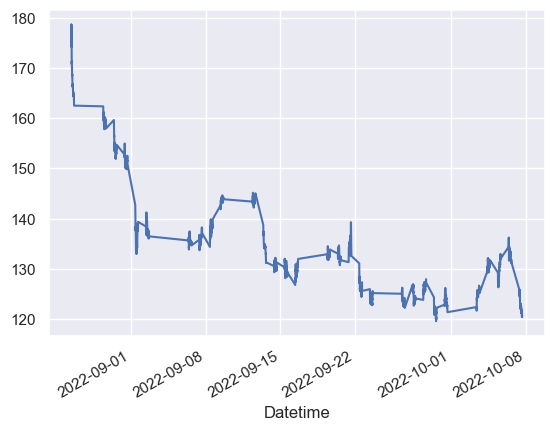

In [33]:
#Plot the True Adj Close Value
stock_df['Close'].plot()

In [34]:
df = stock_df.copy()     # reload copy of df here instead of downloading

---
## Data Preparation

#### Generate trading signal based on price momentum

In [35]:
# Add percentage change actual returns column
df['Actual Returns'] = df['Close'].pct_change()
df = df.dropna()

In [36]:
# Generate buy/sell signal
df['Signal'] = 0.0
# Generate signal to buy stock
df.loc[(df['Actual Returns'] >= 0), 'Signal'] = 1
# Generate signal to sell stock
df.loc[(df['Actual Returns'] < 0), 'Signal'] = 0

# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
df['Entry/Exit'] = df['Signal'].diff()
df = df.dropna()

df.head()

,Open,High,Low,Close,Volume,Actual Returns,Signal,Entry/Exit
Datetime,,,,,,,,
2022-08-26 09:40:00-04:00,176.889999,177.649994,176.240005,176.289993,1095523,-0.003364,0.0,0.0
2022-08-26 09:45:00-04:00,176.294998,176.309998,175.119995,175.274994,1521984,-0.005758,0.0,0.0
2022-08-26 09:50:00-04:00,175.301605,176.270004,175.009995,176.070007,1362449,0.004536,1.0,1.0
2022-08-26 09:55:00-04:00,176.125000,177.379898,176.097305,176.994995,1235215,0.005254,1.0,0.0
2022-08-26 10:00:00-04:00,176.949997,177.104996,174.100006,174.199997,1929217,-0.015791,0.0,-1.0


In [37]:
df['Entry/Exit'].value_counts()


 0.0    1223
 1.0     558
-1.0     558
Name: Entry/Exit, dtype: int64

In [38]:
# Visualize entry position relative to close price
entry = df[df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = df[df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title=(str(ticker) + ': Entry and Exit Points')
)

:Overlay
   .Curve.I          :Curve   [Datetime]   (Close)
   .Scatter.Close.I  :Scatter   [Datetime]   (Close)
   .Scatter.Close.II :Scatter   [Datetime]   (Close)

---
## Backtest trading strategy without Machine Learning

#### Execute trades (buy, hold, sell) and calculate P&L

In [39]:
# Execute trades to calculate gain loss
df, accumulated_shares = trade.gain_loss(df, share_size)

In [40]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_capital:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_capital) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $5,000.00
The total profit/loss of the trading strategy is $-213.15
The trading algorithm resulted in a return on investment of -4.26%


---
## Machine Learning

#### Extract features and target

In [41]:
# Extract features 
# X = df.drop(columns=['Entry/Exit', 'cost/proceeds', 'Position', 'Entry/Exit Position', 'Portfolio Holdings', 'Actual Returns', 'Signal'])
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
X.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-08-26 09:40:00-04:00,176.889999,177.649994,176.240005,176.289993,1095523
2022-08-26 09:45:00-04:00,176.294998,176.309998,175.119995,175.274994,1521984
2022-08-26 09:50:00-04:00,175.301605,176.270004,175.009995,176.070007,1362449
2022-08-26 09:55:00-04:00,176.125000,177.379898,176.097305,176.994995,1235215
2022-08-26 10:00:00-04:00,176.949997,177.104996,174.100006,174.199997,1929217


In [42]:
# Extract target
y = df['Signal']

y.value_counts()

0.0    1193
1.0    1146
Name: Signal, dtype: int64

#### Split train - test data

In [43]:
training_begin = X.index.min()
training_end = X.index.min() + DateOffset(days=25)
print(training_begin)
print(training_end) 

2022-08-26 09:40:00-04:00
2022-09-20 09:40:00-04:00


In [44]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [45]:
X_train.head(1)

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-08-26 09:40:00-04:00,176.889999,177.649994,176.240005,176.289993,1095523


In [46]:
# Scale the features data

scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(1249, 5) (1249,)
(1091, 5) (1091,)


In [47]:
# Save 'trained' scaler
with open(filepath_scaler, 'wb') as f: 
    joblib.dump(X_scaler, f)

#### Train machine learning model using XGBoost

In [48]:
# Instantiate model using XGBClassifier
model = xgb.XGBClassifier()

# Fit/train the model
model = model.fit(X_train_scaled, y_train)

# Use the trained model to predict trading signals
training_signal_predictions = model.predict(X_train_scaled)

In [49]:
# Print classification report on training dataset
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       646
         1.0       1.00      1.00      1.00       603

    accuracy                           1.00      1249
   macro avg       1.00      1.00      1.00      1249
weighted avg       1.00      1.00      1.00      1249



In [50]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
testing_report = classification_report(y_test, testing_signal_predictions)

print(testing_report)


              precision    recall  f1-score   support

         0.0       0.58      0.93      0.72       548
         1.0       0.82      0.34      0.48       543

    accuracy                           0.63      1091
   macro avg       0.70      0.63      0.60      1091
weighted avg       0.70      0.63      0.60      1091



In [51]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['Predicted Signal'] = testing_signal_predictions

# Add in actual returns and calculate trading returns
predictions_df['Close'] = df['Close']
predictions_df['Actual Returns'] = df['Actual Returns']
predictions_df['ML Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted Signal']
predictions_df.to_csv(ticker + ' - predicted_returns.csv')
predictions_df.tail(5)


,Predicted Signal,Close,Actual Returns,ML Returns
Datetime,,,,
2022-10-07 15:40:00-04:00,0,120.750000,-0.000166,-0.000000
2022-10-07 15:45:00-04:00,0,120.544998,-0.001698,-0.000000
2022-10-07 15:50:00-04:00,0,120.465698,-0.000658,-0.000000
2022-10-07 15:55:00-04:00,1,120.779999,0.002609,0.002609
2022-10-07 16:00:00-04:00,0,120.760002,-0.000166,-0.000000


<AxesSubplot:xlabel='Datetime'>

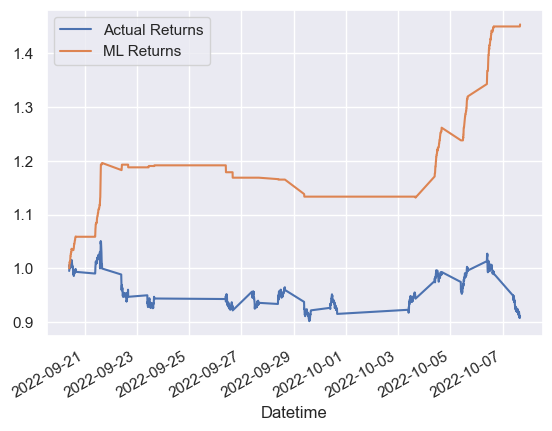

In [52]:
# Calculate and plot the cumulative returns for the `Actual Returns` and the `Algo Returns`
(1 + predictions_df[['Actual Returns', 'ML Returns']]).cumprod().plot()

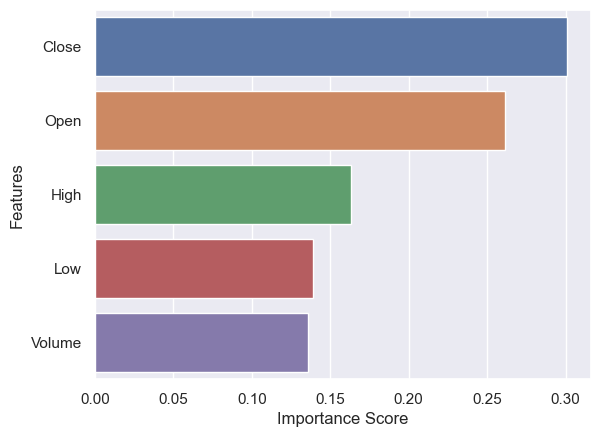

In [53]:
# Show ranking of importance score of features for this dataset
imp_score = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
features = pd.DataFrame(X.columns, columns=['Features'])
feature_imp = pd.concat([features,imp_score], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
plt.show()

---
## Machine Learning - Backtest test dataset using predicted signal

#### Execute trades (buy, hold, sell) and calculate P&L

In [54]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
predictions_df['Entry/Exit'] = predictions_df['Predicted Signal'].diff()
predictions_df.head()


,Predicted Signal,Close,Actual Returns,ML Returns,Entry/Exit
Datetime,,,,,
2022-09-20 09:40:00-04:00,0,131.960007,-0.004977,-0.000000,NaN
2022-09-20 09:45:00-04:00,1,132.100006,0.001061,0.001061,1.0
2022-09-20 09:50:00-04:00,1,132.489899,0.002951,0.002951,0.0
2022-09-20 09:55:00-04:00,0,132.509995,0.000152,0.000000,-1.0
2022-09-20 10:00:00-04:00,1,132.910004,0.003019,0.003019,1.0


In [55]:
predictions_df['Entry/Exit'].value_counts()

 0.0    892
 1.0     99
-1.0     99
Name: Entry/Exit, dtype: int64

In [56]:
predictions_df.shape

(1091, 5)

In [57]:
# Call function to calculate P&L
predictions_df, accumulated_shares = trade.gain_loss(predictions_df, share_size)

# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_capital:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = predictions_df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# Calculate the return on investment (ROI)
roi = (total_profit_loss / initial_capital) * 100

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $5,000.00
The total profit/loss of the trading strategy is $75.60
The trading algorithm resulted in a return on investment of 1.51%


In [58]:
# Save trained model
with open(filepath_model, 'wb') as f: 
    # pickle.dump(model, f)
    joblib.dump(model, f)